In [58]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [59]:
#%%########################################################################
# Function to simulate dataset of voting, iss recs, and latent states
###########################################################################
def simulate(delta,alpha_o,alpha_c,mu_g,mu_b,Lambda,theta,a_y,b_y,a_n,b_n,a_u,b_u,N):
    '''
    Parameters
    ----------
    delta               = probability of obvious (versus contentious)
    alpha_o             = probability of good proposal conditional on obvious
    alpha_c             = probability of good proposal conditional on contentious
    mu_g                = probability that ISS recommends yes for good proposals
    mu_b                = probability that ISS recommends yes for bad proposals
    Lambda              = fraction of votes that are informed always
    theta               = fraction of votes that are informed on obvious proposals (flip beta coin on contentious)
    a_y                 = beta distr parameter for partially informed (for contentious proposals) if ISS = Y
    b_y                 = beta distr parameter for partially informed (for contentious proposals) if ISS = Y
    a_n                 = beta distr parameter for partially informed (for contentious proposals) if ISS = N
    b_n                 = beta distr parameter for partially informed (for contentious proposals) if ISS = N
    a_u                 = beta distr parameter for uninformed (for all proposals)
    b_u                 = beta distr parameter for uninformed (for all proposals)    
    N                   = number of simulated datapoints
    '''
    cols = ['node','obvious','good','iss_rec','v','v_informed','v_PI', 'v_UI']
    idx  = np.arange(N)
    df = pd.DataFrame(dtype=float,columns=cols,index=idx)

    # Generate states of nature
    df['obvious'] = scipy.stats.bernoulli.rvs(delta, size=N)
    df['good']    = np.where(df.obvious==1, scipy.stats.bernoulli.rvs(alpha_o, size=N), scipy.stats.bernoulli.rvs(alpha_c, size=N))
    df['iss_rec'] = np.where(df.good==1, scipy.stats.bernoulli.rvs(mu_g, size=N), scipy.stats.bernoulli.rvs(mu_b, size=N))


    # Generate voting for individual voter types
    df['v_informed'] = np.where(df.good==1, Lambda, 0)
    df['v_PI']  = theta * np.where(df.iss_rec==1, scipy.stats.beta.rvs(a_y, b_y, size=N), scipy.stats.beta.rvs(a_n, b_n, size=N))
    df.loc[(df.obvious==1) & (df.good==1),'v_PI'] = theta
    df.loc[(df.obvious==1) & (df.good==0),'v_PI'] = 0.0
    df['v_UI']  = (1-Lambda-theta) * scipy.stats.beta.rvs(a_u, b_u, size=N)

    # Generate the votes
    df.v = df.v_informed + df.v_PI + df.v_UI
    return df

In [72]:
#%%########################################################################
# Function that summarizes simulated data 
#    and plots various vote share distributions
###########################################################################
def make_plots(delta,alpha_o,alpha_c,mu_g,mu_b,Lambda,theta,a_y,b_y,a_n,b_n,a_u,b_u,N):
    df = simulate(delta,alpha_o,alpha_c,mu_g,mu_b,Lambda,theta,a_y,b_y,a_n,b_n,a_u,b_u,N)

    ##### Plot the unconditional distributions and vote distribution conditional on either good or ISS
    fig, axes = plt.subplots(5, 1, figsize=(10,16), sharex=True,sharey=True)
    numbins = 50
    fontsz = 10
    axes[0].hist(df.v, bins=numbins) 
    axes[1].hist(df.loc[(df.good==1),'v'], bins=numbins) 
    axes[2].hist(df.loc[(df.good==0),'v'], bins=numbins) 
    axes[3].hist(df.loc[(df.iss_rec==1),'v'], bins=numbins) 
    axes[4].hist(df.loc[(df.iss_rec==0),'v'], bins=numbins) 
    axes[0].set_title('Unconditional Distribution')
    axes[1].set_title('Distribution Conditional on Good')
    axes[2].set_title('Distribution Conditional on Bad')
    axes[3].set_title('Distribution Conditional on ISS=Y')
    axes[4].set_title('Distribution Conditional on ISS=N')

    limits = axes[0].get_ylim()
    axes[0].axvline(Lambda, color='k', linestyle='dotted')
    axes[0].text(Lambda, -(limits[1]-limits[0])/10, r'$\lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[0].axvline(Lambda + theta, color='k', linestyle='dotted')
    axes[0].text(Lambda + theta, -(limits[1]-limits[0])/10,r'$\lambda + \theta$',horizontalalignment='center',fontsize=fontsz)
    axes[0].axvline(1-Lambda, color='k', linestyle='dotted')
    axes[0].text(1-Lambda,-(limits[1]-limits[0])/10, r'$1- \lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[0].axvline(1-Lambda - theta, color='k', linestyle='dotted')
    axes[0].text(1-Lambda - theta, -(limits[1]-limits[0])/10 ,r'$1- \lambda - \theta$',horizontalalignment='center',fontsize=fontsz)

    limits = axes[1].get_ylim()
    axes[1].axvline(0.5, color='k', linestyle='dotted')
    axes[1].text(0.5, -(limits[1]-limits[0])/10, r'0.5',horizontalalignment='center',fontsize=fontsz)
    limits = axes[1].get_ylim()
    axes[2].axvline(0.5, color='k', linestyle='dotted')
    axes[2].text(0.5, -(limits[1]-limits[0])/10, r'0.5',horizontalalignment='center',fontsize=fontsz)

    limits = axes[3].get_ylim()
    axes[3].axvline(Lambda, color='k', linestyle='dotted')
    axes[3].text(Lambda, -(limits[1]-limits[0])/10, r'$\lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[3].axvline(Lambda + theta, color='k', linestyle='dotted')
    axes[3].text(Lambda + theta, -(limits[1]-limits[0])/10,r'$\lambda + \theta$',horizontalalignment='center',fontsize=fontsz)
    axes[3].axvline(1-Lambda, color='k', linestyle='dotted')
    axes[3].text(1-Lambda,-(limits[1]-limits[0])/10, r'$1- \lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[3].axvline(1-Lambda - theta, color='k', linestyle='dotted')
    axes[3].text(1-Lambda - theta, -(limits[1]-limits[0])/10 ,r'$1- \lambda - \theta$',horizontalalignment='center',fontsize=fontsz)

    limits = axes[4].get_ylim()
    axes[4].axvline(Lambda, color='k', linestyle='dotted')
    axes[4].text(Lambda, -(limits[1]-limits[0])/8, r'$\lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[4].axvline(Lambda + theta, color='k', linestyle='dotted')
    axes[4].text(Lambda + theta, -(limits[1]-limits[0])/8,r'$\lambda + \theta$',horizontalalignment='center',fontsize=fontsz)
    axes[4].axvline(1-Lambda, color='k', linestyle='dotted')
    axes[4].text(1-Lambda,-(limits[1]-limits[0])/8, r'$1- \lambda$',horizontalalignment='center',fontsize=fontsz)
    axes[4].axvline(1-Lambda - theta, color='k', linestyle='dotted')
    axes[4].text(1-Lambda - theta, -(limits[1]-limits[0])/8 ,r'$1- \lambda - \theta$',horizontalalignment='center',fontsize=fontsz)
    fig.tight_layout()
    
    
    
    ##### Provide statistics of simulation relative to assumed parameters
    print('Fraction obvious is:',  np.round(df.obvious.mean(),3),'and delta=',delta)
    print('Fraction good conditional on obvious is: \t',  np.round(df[df.obvious==1].good.mean(),3),'and alpha_o=',alpha_o)
    print('Fraction good conditional on contentious is:\t',np.round(df[df.obvious==0].good.mean(),3),'and alpha_c=',alpha_c)
    print('Fraction ISS=Y conditional on good is:\t', np.round(df[df.good==1].iss_rec.mean(),3),'and mu_g=',mu_g)
    print('Fraction ISS=Y conditional on bad is:\t',  np.round(df[df.good==0].iss_rec.mean(),3),'and mu_b=',mu_b)

    print('Vote share by informed conditional on good: ', np.round(df.loc[(df.good==1),'v_informed'].mean(),3), 'and lambda=',Lambda)
    print('Vote share by informed conditional on bad: ', np.round(df.loc[(df.good==0),'v_informed'].mean(),3), 'and expected=0')
    print('Average vote share by partially informed informed conditional on obvious & good: ', np.round(df.loc[(df.obvious==1) & (df.good==1),'v_PI'].mean(),3), '\tand theta=',theta)
    print('Average vote share by partially informed informed conditional on obvious & bad:  ',  np.round(df.loc[(df.obvious==1) & (df.good==0),'v_PI'].mean(),3), '\tand expected=0')
    print('Average vote share by partially informed informed conditional on contentious & ISS=Y: ', np.round(df.loc[(df.obvious==0) & (df.iss_rec==1),'v_PI'].mean(),3), '\tand expected=theta*a_y/(a_y+b_y)]:',np.round(theta*a_y/(a_y+b_y),3))
    print('Average vote share by partially informed informed conditional on contentious & ISS=N: ', np.round(df.loc[(df.obvious==0) & (df.iss_rec==0),'v_PI'].mean(),3), '\tand expected=theta*a_n/(a_n+b_n)]:',np.round(theta*a_n/(a_n+b_n),3))
    print('Average vote share by uninformed', np.round(df.v_UI.mean(),3), '\tand expected=(1-lambda-theta)*a_u/(a_u+b_u)]:',np.round((1-Lambda-theta)*a_u/(a_u+b_u),3))        
    
    
    
    
    
    ##### Plot the 6 component distributions
    fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=False)
    numbins = 50
    fontsz = 10
    axes[0,0].hist(df.loc[(df.obvious==1) & (df.good==1),'v'], bins=numbins) 
    axes[0,1].hist(df.loc[(df.obvious==1) & (df.good==0),'v'], bins=numbins) 
    axes[1,0].hist(df.loc[(df.obvious==0) & (df.good==1) & (df.iss_rec==1),'v'], bins=numbins) 
    axes[1,1].hist(df.loc[(df.obvious==0) & (df.good==1) & (df.iss_rec==0),'v'], bins=numbins) 
    axes[2,0].hist(df.loc[(df.obvious==0) & (df.good==0) & (df.iss_rec==1),'v'], bins=numbins) 
    axes[2,1].hist(df.loc[(df.obvious==0) & (df.good==0) & (df.iss_rec==0),'v'], bins=numbins) 
    axes[0,0].set_title("Obvious and Good",fontsize=fontsz)
    axes[0,1].set_title('Obvious and Bad',fontsize=fontsz)
    axes[1,0].set_title('Contentious and Good and ISS=Y',fontsize=fontsz)
    axes[1,1].set_title('Contentious and Good and ISS=N',fontsize=fontsz)
    axes[2,0].set_title('Contentious and Bad and ISS=Y',fontsize=fontsz)
    axes[2,1].set_title('Contentious and Bad and ISS=N',fontsize=fontsz)
    fig.suptitle('Component Distributions',fontsize=20)

    axes[0,0].axvline(Lambda + theta, color='k', linestyle='dotted')
    limits = axes[0, 0].get_ylim()
    axes[0,0].text(Lambda + theta, -(limits[1]-limits[0])/8,r'$\lambda + \theta$',horizontalalignment='center',fontsize=fontsz)

    axes[0,1].axvline(1-Lambda - theta, color='k', linestyle='dotted')
    limits = axes[0, 1].get_ylim()
    axes[0,1].text(1-Lambda - theta, -(limits[1]-limits[0])/8 ,r'$1- \lambda - \theta$',horizontalalignment='center',fontsize=fontsz)

    axes[1,0].axvline(Lambda, color='k', linestyle='dotted')
    limits = axes[1, 0].get_ylim()
    axes[1,0].text(Lambda, -(limits[1]-limits[0])/8, r'$\lambda$',horizontalalignment='center',fontsize=fontsz)

    axes[1,1].axvline(Lambda, color='k', linestyle='dotted')
    limits = axes[1, 1].get_ylim()
    axes[1,1].text(Lambda, -(limits[1]-limits[0])/8, r'$\lambda$',horizontalalignment='center',fontsize=fontsz)

    axes[2,0].axvline(1-Lambda, color='k', linestyle='dotted')
    limits = axes[2, 0].get_ylim()
    axes[2,0].text(1-Lambda,-(limits[1]-limits[0])/5, r'$1- \lambda$',horizontalalignment='center',fontsize=fontsz)

    axes[2,1].axvline(1-Lambda, color='k', linestyle='dotted')
    limits = axes[2, 1].get_ylim()
    axes[2,1].text(1-Lambda,-(limits[1]-limits[0])/5, r'$1- \lambda$',horizontalalignment='center',fontsize=fontsz)
    fig.tight_layout()
    
    return

Fraction obvious is: 0.06 and delta= 0.06
Fraction good conditional on obvious is: 	 0.799 and alpha_o= 0.8
Fraction good conditional on contentious is:	 0.2 and alpha_c= 0.2
Fraction ISS=Y conditional on good is:	 0.748 and mu_g= 0.75
Fraction ISS=Y conditional on bad is:	 0.251 and mu_b= 0.25
Vote share by informed conditional on good:  0.36 and lambda= 0.36
Vote share by informed conditional on bad:  0.0 and expected=0
Average vote share by partially informed informed conditional on obvious & good:  0.57 	and theta= 0.57
Average vote share by partially informed informed conditional on obvious & bad:   0.0 	and expected=0
Average vote share by partially informed informed conditional on contentious & ISS=Y:  0.38 	and expected=theta*a_y/(a_y+b_y)]: 0.38
Average vote share by partially informed informed conditional on contentious & ISS=N:  0.162 	and expected=theta*a_n/(a_n+b_n)]: 0.163
Average vote share by uninformed 0.035 	and expected=(1-lambda-theta)*a_u/(a_u+b_u)]: 0.035


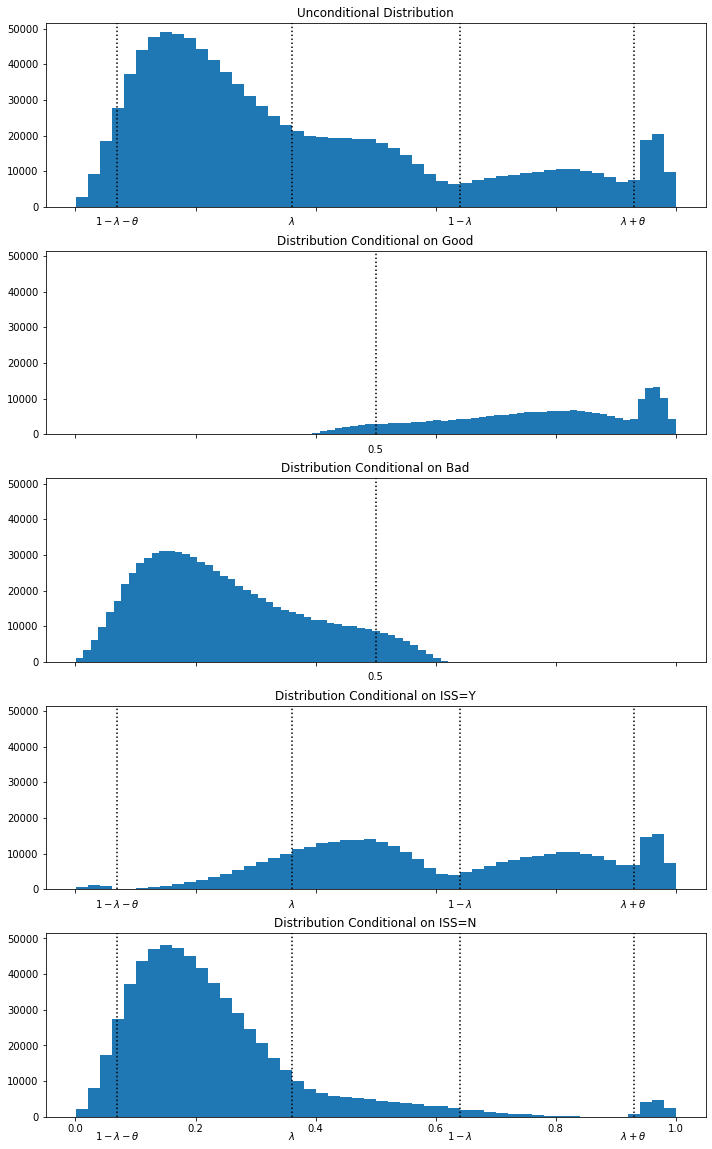

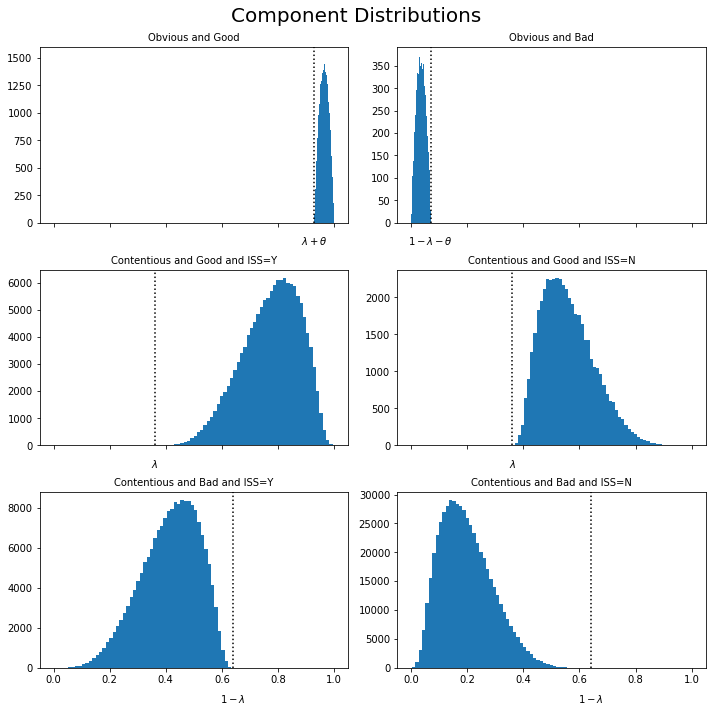

In [73]:
#%%########################################################################
# Define the parameters and run simulation
###########################################################################
'''
Parameters
----------
delta               = probability of obvious (versus contentious)
alpha_o             = probability of good proposal conditional on obvious
alpha_c             = probability of good proposal conditional on contentious
mu_g                = probability that ISS recommends yes for good proposals
mu_b                = probability that ISS recommends yes for bad proposals
Lambda              = fraction of votes that are informed always
theta               = fraction of votes that are informed on obvious proposals (flip beta coin on contentious)
a_y                 = beta distr parameter for partially informed (for contentious proposals) if ISS = Y
b_y                 = beta distr parameter for partially informed (for contentious proposals) if ISS = Y
a_n                 = beta distr parameter for partially informed (for contentious proposals) if ISS = N
b_n                 = beta distr parameter for partially informed (for contentious proposals) if ISS = N
a_u                 = beta distr parameter for uninformed (for all proposals)
b_u                 = beta distr parameter for uninformed (for all proposals)    
N                   = number of simulated datapoints
'''
delta   = 0.06
alpha_o = 0.8 
alpha_c = 0.2
mu_g    = 0.75
mu_b    = 0.25
Lambda  = 0.36
theta   = 0.57
a_y     = 4
b_y     = 2
a_n     = 2
b_n     = 5
a_u     = 2
b_u     = 2

N = 1000000
make_plots(delta,alpha_o,alpha_c,mu_g,mu_b,Lambda,theta,a_y,b_y,a_n,b_n,a_u,b_u,N)